# TEST worksheet, to be prettyfied/explained.  

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

%load_ext autoreload
%autoreload 2
%aimport scqubits

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scqubits as scq

In [3]:
# from pathos.multiprocessing import ProcessingPool    
# pool = ProcessingPool(nodes=8)

# map_fun=pool.map
map_fun=map

## Let us show what units the library currently assumes

In [4]:
scq.get_units()

'GHz'

In [5]:
scq.get_units_time_label("MHz")

'$\\mu s$'

## Let's define a few qubits and list the noise channels that they support

### Transmon

In [6]:
transmon = scq.Transmon(
    EJ=0.5,
    EC=12.0,
    ng=0.3,
    ncut=150
)
print(transmon)
transmon.supported_noise_channels()

TRANSMON
 ———— PARAMETERS ————
EJ	: 0.5
EC	: 12.0
ng	: 0.3
ncut	: 150
truncated_dim	: None
Hilbert space dimension	: 301


['tphi_1_over_f_cc',
 'tphi_1_over_f_ng',
 't1_capacitive_loss',
 't1_charge_impedance']

Plot all supported noise channels, in currently set units 

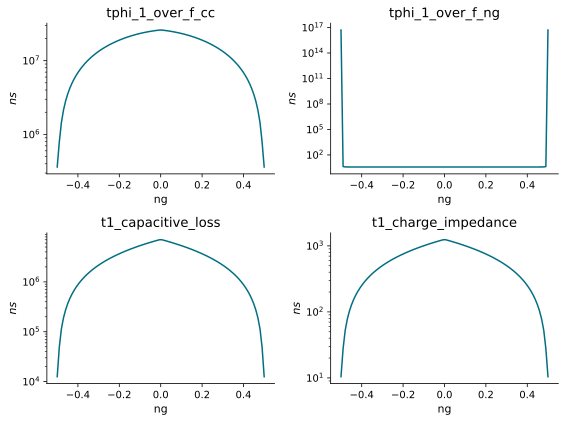

In [7]:
transmon.plot_noise(param_name='ng', param_vals=np.linspace(-0.5, 0.5, 100));

Scale the results, so that end up with time in units of $\mu s$

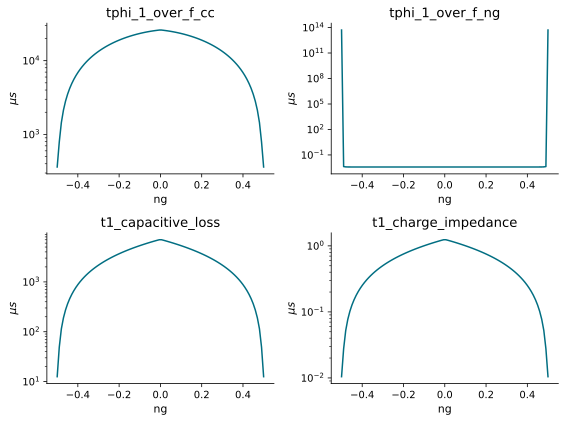

In [8]:
transmon.plot_noise(param_name='ng', param_vals=np.linspace(-0.5, 0.5, 100), scale=1e-3, ylabel=r"$\mu s$");

Can also plot just one channel, and provide standard plotting options. 

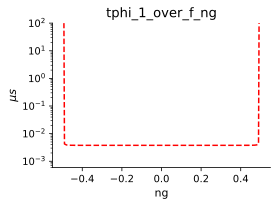

In [12]:
transmon.plot_noise(noise_channels='tphi_1_over_f_ng', param_name='ng', 
                    param_vals=np.linspace(-0.5, 0.5, 100), 
                    scale=1e-3, ylabel=r"$\mu s$", linestyle='--', color='red', ylim=(None, 1e2));

Can also provide a list of channels, each with its own options. 

### Tunable Transmon

In [21]:
tune_tmon = scq.TunableTransmon(
    EJmax=20.0,
    EC=0.5,
    d=0.00,
    flux=0.0,
    ng=0.3,
    ncut=150
)
print(tune_tmon)
tune_tmon.supported_noise_channels()

TUNABLETRANSMON
 ———— PARAMETERS ————
EJmax	: 20.0
EC	: 0.5
d	: 0.0
flux	: 0.0
ng	: 0.3
ncut	: 150
truncated_dim	: None
Hilbert space dimension	: 301


['tphi_1_over_f_flux',
 'tphi_1_over_f_cc',
 'tphi_1_over_f_ng',
 't1_capacitive_loss',
 't1_flux_bias_line',
 't1_charge_impedance']

(3, 2)
False


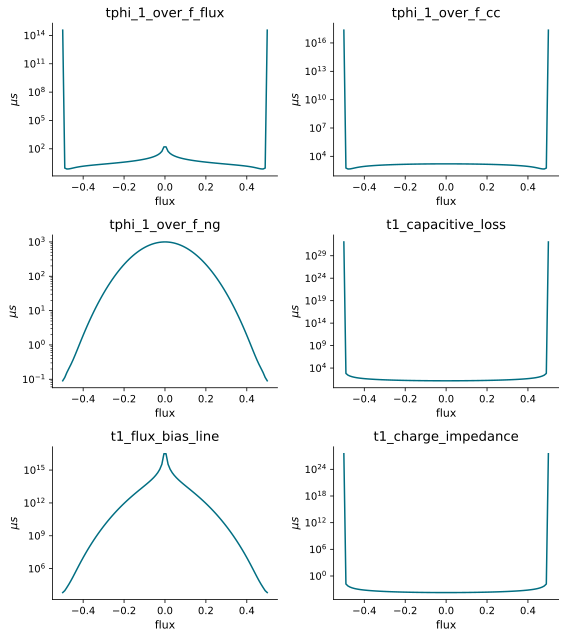

In [22]:
tune_tmon.plot_noise(param_name='flux', param_vals=np.linspace(-0.5, 0.5, 100), scale=1e-3, ylabel=r"$\mu s$");

In [23]:
transmon = scq.Transmon(
    EJ=0.5,
    EC=12.0,
    ng=0.3,
    ncut=150
)
print(transmon)
transmon.supported_noise_channels()

TRANSMON
 ———— PARAMETERS ————
EJ	: 0.5
EC	: 12.0
ng	: 0.3
ncut	: 150
truncated_dim	: None
Hilbert space dimension	: 301


['tphi_1_over_f_cc',
 'tphi_1_over_f_ng',
 't1_capacitive_loss',
 't1_charge_impedance']

In [24]:
fluxonium = scq.Fluxonium(
    EJ=8.9,
    EC=2.5,
    EL=0.5,
    cutoff = 150,
    flux = 0.5
)
print(fluxonium)
fluxonium.supported_noise_channels()

FLUXONIUM
 ———— PARAMETERS ————
EJ	: 8.9
EC	: 2.5
EL	: 0.5
flux	: 0.5
cutoff	: 150
truncated_dim	: None
Hilbert space dimension	: 150


['tphi_1_over_f_cc',
 'tphi_1_over_f_flux',
 't1_flux_bias_line',
 't1_capacitive_loss',
 't1_inductive_loss',
 't1_charge_impedance']

In [29]:
# parameters for the flux qubit
RATIO = 60.0
ALPHA = 0.8
flux_qubit = scq.FluxQubit(
    EJ1 = 1.0, 
    EJ2 = 1.0, 
    EJ3 = ALPHA*1.0, 
    ECJ1 = 1.0/RATIO, 
    ECJ2 = 1.0/RATIO, 
    ECJ3 = 1.0/ALPHA/RATIO, 
    ECg1 = 50.0/RATIO, 
    ECg2 = 50.0/RATIO, 
    ng1 = 0.0, 
    ng2 = 0.0, 
    flux = 0.4, 
    ncut = 10,
)
print(flux_qubit)
flux_qubit.supported_noise_channels()

FLUXQUBIT
 ———— PARAMETERS ————
EJ1	: 1.0
EJ2	: 1.0
EJ3	: 0.8
ECJ1	: 0.016666666666666666
ECJ2	: 0.016666666666666666
ECJ3	: 0.020833333333333332
ECg1	: 0.8333333333333334
ECg2	: 0.8333333333333334
ng1	: 0.0
ng2	: 0.0
flux	: 0.4
ncut	: 10
truncated_dim	: None
Hilbert space dimension	: 441


['tphi_1_over_f_cc1',
 'tphi_1_over_f_cc2',
 'tphi_1_over_f_cc3',
 'tphi_1_over_f_cc']

In [30]:
phi_grid = scq.Grid1d(-6*np.pi, 6*np.pi, 200)

EJ_CONST = 1/3.95  # note that EJ and ECJ are interrelated

zero_pi = scq.ZeroPi(
    grid = phi_grid,
    EJ   = EJ_CONST,
    EL   = 10.0**(-2),
    ECJ  = 1/(8.0*EJ_CONST),
    EC = None,
    ECS  = 10.0**(-3),
    ng   = 0.1,
    flux = 0.23,
    ncut = 30
)
print(zero_pi)
zero_pi.supported_noise_channels()

ZEROPI
 ———— PARAMETERS ————
EJ	: 0.2531645569620253
EL	: 0.01
ECJ	: 0.4937500000000001
EC	: 0.001002029426686961
dEJ	: 0
dCJ	: 0
ng	: 0.1
flux	: 0.23
grid	:     Grid1d ......
max_val	: 18.84955592153876
min_val	: -18.84955592153876
pt_count	: 200
ncut	: 30
truncated_dim	: None
Hilbert space dimension	: 12200


['tphi_1_over_f_cc', 'tphi_1_over_f_fluxt1_flux_bias_linet1_inductive_loss']

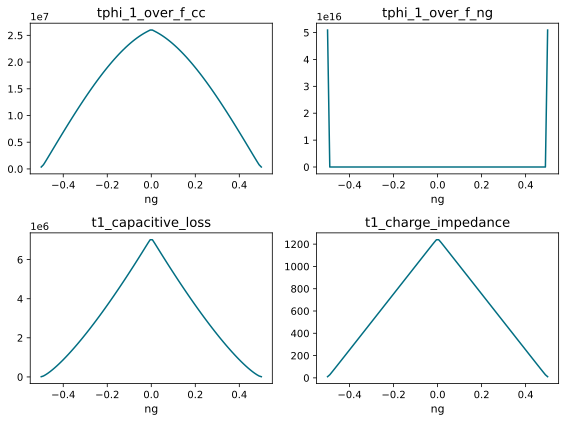

In [10]:
# transmon.plot_noise(param_name='ng', param_vals=np.linspace(-0.5, 0.5, 3), noise_channels='tphi_1_over_f_ng')
transmon.plot_noise(param_name='ng', param_vals=np.linspace(-0.5, 0.5, 100), i=1, j=0);

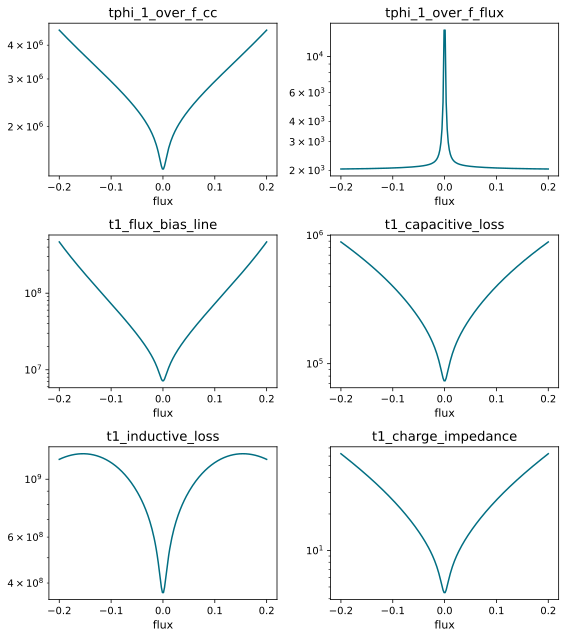

In [21]:
fig, ax=fluxonium.plot_noise(param_name='flux', param_vals=np.linspace(-0.2, 0.2, 200));

In [ ]:
ax[0,1]

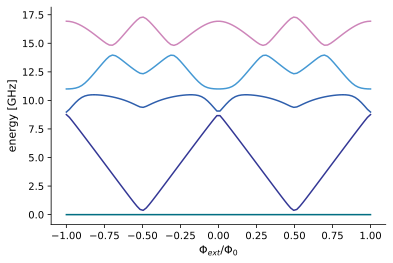

In [12]:
param_list = np.linspace(-1, 1, 100)
fluxonium.plot_evals_vs_paramvals('flux', param_list, evals_count=5, subtract_ground=True);

TODO fix issue with 1_over_f_cc()

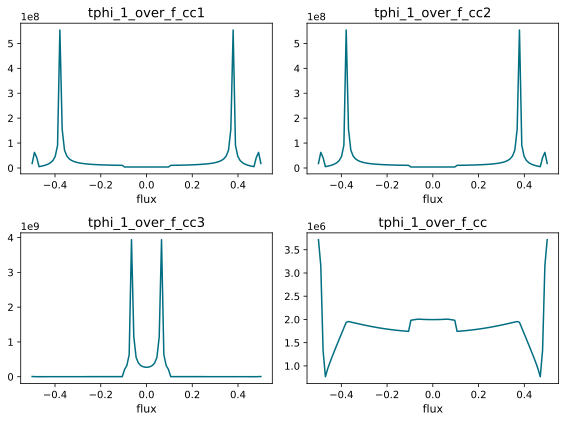

In [14]:
flux_qubit.plot_noise(param_name='flux', param_vals=np.linspace(-0.5, 0.5, 100));

## T1 due to capacitive loss (i.e. delectric loss)

We can look at the rate/time from any state i to any j, or at a compbined rate/time by supplying the `total=True` argument.

Text(0.5, 0, 'flux')

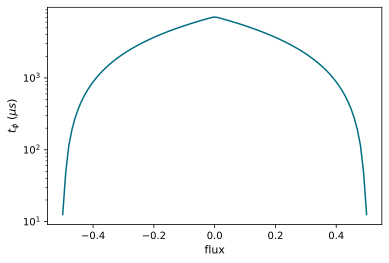

In [14]:
param_array=np.linspace(-0.5, 0.5, 100)

def calc(param , qubit=transmon): 
    return qubit.set_and_return('ng', param).t1_capacitive_loss(1,0) * 1e-3

results_array=list(map_fun(calc, param_array))

fig, ax=plt.subplots(1,1)
ax.plot(param_array, results_array)
ax.set_yscale('log')
ax.set_ylabel(r'$t_\phi$ ($\mu s$)')
ax.set_xlabel(r'flux')
# ax.set_ylim(None, 1e3);

Can also return a rate and not time. The units (currently) should correponds to $2\pi$ * Hamiltonian energy units

In [58]:
transmon.ng=0.3
transmon.t1_capacitive_loss(1,0, get_rate=True)

4.615018306554074e-07

Here we can pass the effective capacitive quality factor as a frequency/energy dependent function. Let's also add up both 1->0 and 0->1 rates. Let us also work at a hotter than defualt (0.015K) temperature, say 40mK. 

Text(0.5, 0, 'flux')

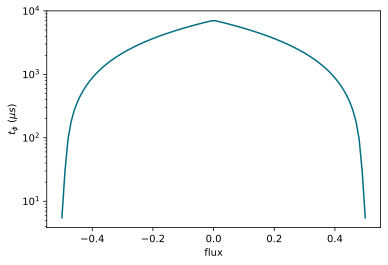

In [59]:
param_array=np.linspace(-0.5, 0.5, 100)

def calc(param , qubit=transmon): 
    
    def Q_cap(omega):
        #see Smith et al 2020
        return 1e6 * ( 2*np.pi * 6e9/np.abs(scq.to_standard_units(omega)))**0.7
    
    return qubit.set_and_return('ng', param).t1_capacitive_loss(1, 0, 
                                                                Q_cap=Q_cap,
                                                                T=0.040,
                                                                total=True,
                                                               ) * 1e-3

results_array=list(map_fun(calc, param_array))

fig, ax=plt.subplots(1,1)
ax.plot(param_array, results_array)
ax.set_yscale('log')
ax.set_ylabel(r'$t_\phi$ ($\mu s$)')
ax.set_xlabel(r'flux')
# ax.set_ylim(None, 1e3);
# print(results_array)

## T1 due to inductive loss (i.e. quasiparticle tunneling)

In [60]:
fluxonium.supported_noise_channels()

['tphi_1_over_f_cc',
 'tphi_1_over_f_flux',
 't1_flux_bias_line',
 't1_capacitive_loss',
 't1_inductive_loss',
 't1_charge_impedance']

Text(0.5, 0, 'flux')

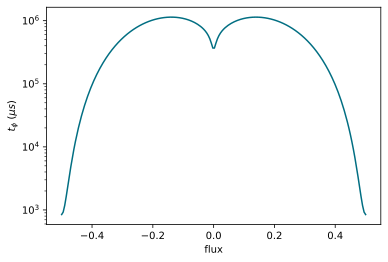

In [61]:
param_array=np.linspace(-0.5, 0.5, 200)

def calc(param , qubit=fluxonium): 
    
    return qubit.set_and_return('flux', param).t1_inductive_loss(1, 0, 
                                                                T=0.10,
                                                                total=True
                                                               ) * 1e-3

results_array=list(map_fun(calc, param_array))

fig, ax=plt.subplots(1,1)
ax.plot(param_array, results_array)
ax.set_yscale('log')
ax.set_ylabel(r'$t_\phi$ ($\mu s$)')
ax.set_xlabel(r'flux')
# ax.set_ylim(None, 1e3);
# print(results_array)

## T1 due to arbitrary noise channel 
Users can pass in their their own spectral density and the relevant operator. This is done like so (Here i've just made up a noise channel). Let's look at a transition between higher levels, say 3 and 2, and sum and up and down rates together to get an effective t1

In [62]:
def spec_dens(omega, T=0.020, q_c=1e6, qubit=fluxonium):
    therm_ratio = scq.calc_therm_ratio(omega, T)
    s = 2 * 8 * qubit.EC / q_c * (1/np.tanh(0.5 * np.abs(therm_ratio))) / (1 + np.exp(-therm_ratio))
    # We assume system energies (i.e. EC) is specificed in frequency units, 
    # hence have to convert to angular frequency.
    s *= 2 * np.pi
    return s

noise_op = fluxonium.n_operator()

fluxonium.t1(i=3, j=2, noise_op=noise_op, spec_dens=spec_dens, total=True) * 1e-3 #in microseconds


27.371839738919142

## T1 due to charge coupling to an impedance
Here we consider coupling to an open tansmission line. 

Text(0.5, 0, 'flux')

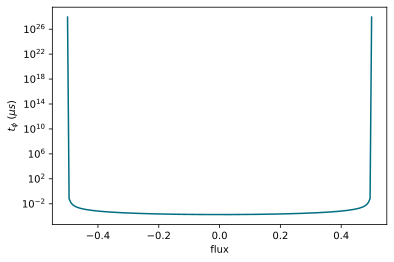

In [63]:
param_array=np.linspace(-0.5, 0.5, 200)

tune_tmon.ng=0.0

def calc(param , qubit=tune_tmon): 
    return qubit.set_and_return('flux', param).t1_charge_impedance(1, 0, 
                                                                T=0.015,
                                                                ReZ=50,
                                                                total=False,
                                                               ) * 1e-3

results_array=list(map_fun(calc, param_array))

fig, ax=plt.subplots(1,1)
ax.plot(param_array, results_array)
ax.set_yscale('log')
ax.set_ylabel(r'$t_\phi$ ($\mu s$)')
ax.set_xlabel(r'flux')
# ax.set_ylim(None, 1e3);
# print(results_array)

## T1 due to bias flux line 


In [13]:
fluxonium.supported_noise_channels()

['tphi_1_over_f_cc',
 'tphi_1_over_f_flux',
 't1_flux_bias_line',
 't1_capacitive_loss',
 't1_inductive_loss',
 't1_charge_impedance']

Text(0.5, 0, 'flux')

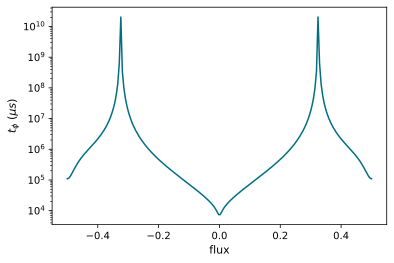

In [14]:
param_array=np.linspace(-0.5, 0.5, 200)

def calc(param , qubit=fluxonium): 
    return qubit.set_and_return('flux', param).t1_flux_bias_line(1, 0, 
                                                                T=0.015,
                                                                ReZ=50,
                                                                total=False,
                                                               ) * 1e-3

results_array=list(map_fun(calc, param_array))

fig, ax=plt.subplots(1,1)
ax.plot(param_array, results_array)
ax.set_yscale('log')
ax.set_ylabel(r'$t_\phi$ ($\mu s$)')
ax.set_xlabel(r'flux')
# ax.set_ylim(None, 1e3);
# print(results_array)

Text(0.5, 0, 'flux')

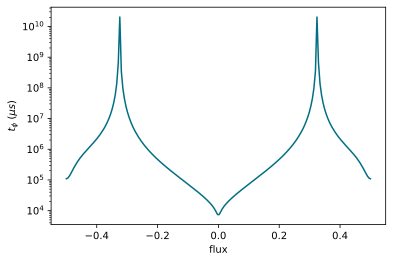

In [65]:
param_array=np.linspace(-0.5, 0.5, 200)

def calc(param , qubit=fluxonium): 
    return qubit.set_and_return('flux', param).t1_flux_bias_line(1, 0, 
                                                                T=0.015,
                                                                ReZ=50,
                                                                total=False,
                                                               ) * 1e-3

results_array=list(map_fun(calc, param_array))

fig, ax=plt.subplots(1,1)
ax.plot(param_array, results_array)
ax.set_yscale('log')
ax.set_ylabel(r'$t_\phi$ ($\mu s$)')
ax.set_xlabel(r'flux')
# ax.set_ylim(None, 1e3);
# print(results_array)

In [66]:
scq.to_standard_units(1)

1000000000.0

## tphi  due to 1/f flux noise

In [18]:
# qubit=tune_tmon
qubit=fluxonium

Text(0.5, 0, 'flux')

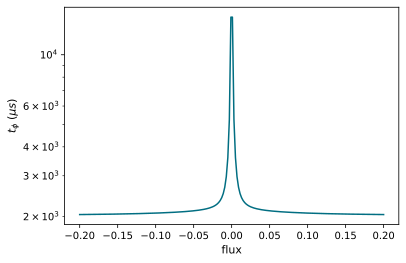

In [20]:
param_array=np.linspace(-0.2, 0.2, 200)
# tphi_array=[qubit.set_and_return('flux', param).tphi_1_over_f_flux() * 1e-3 for param in param_array]

def calc(param , qubit=qubit): return qubit.set_and_return('flux', param).tphi_1_over_f_flux() #* 1e-3
results_array=list(map_fun(calc, param_array))

fig, ax=plt.subplots(1,1)
ax.plot(param_array, results_array)
ax.set_yscale('log')
ax.set_ylabel(r'$t_\phi$ ($\mu s$)')
ax.set_xlabel(r'flux')
# ax.set_ylim(None, 1e3);

## tphi  due to 1/f charge noise

In [69]:
qubit=tune_tmon

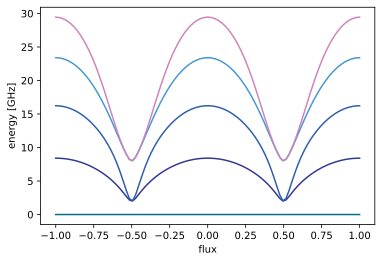

In [70]:
param_list = np.linspace(-1, 1, 100)
qubit.plot_evals_vs_paramvals('flux', param_list, evals_count=5, subtract_ground=True);

Text(0.5, 0, 'ng')

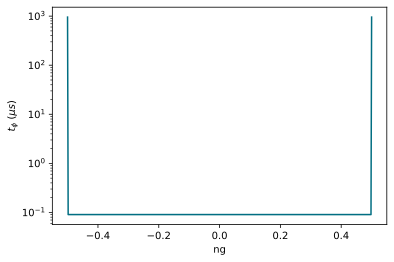

In [71]:
param_array=np.linspace(-0.5, 0.5, 500)
tphi_array=[qubit.set_and_return('ng', param).tphi_1_over_f_ng() * 1e-3 for param in param_array]

fig, ax=plt.subplots(1,1)
ax.plot(param_array, tphi_array)
ax.set_yscale('log')
ax.set_ylabel(r'$t_\phi$ ($\mu s$)')
ax.set_xlabel(r'ng')
# ax.set_ylim(None, 1e3);

## tphi  due to 1/f critical current noise
flux qubit needs to redefine varoius basic things as it has multiple junctions.

In [72]:
qubit=flux_qubit

consider charge noise to only the 1st junction

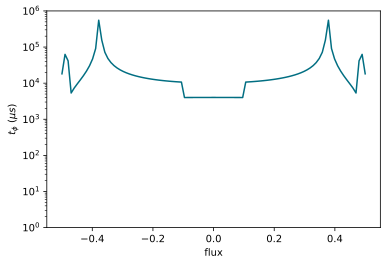

In [73]:
param_array=np.linspace(-0.5, 0.5, 100)
# tphi_array=[qubit.set_and_return('flux', param).tphi_1_over_f_cc3() * 1e-3 for param in param_array]

def calc(param , qubit=qubit): return qubit.set_and_return('flux', param).tphi_1_over_f_cc1() * 1e-3
results_array=list(map_fun(calc, param_array))


fig, ax=plt.subplots(1,1)
ax.plot(param_array, results_array)
ax.set_yscale('log')
ax.set_ylabel(r'$t_\phi$ ($\mu s$)')
ax.set_xlabel(r'flux')
ax.set_ylim(1, 1e6);

... and now combine the noise from all of them

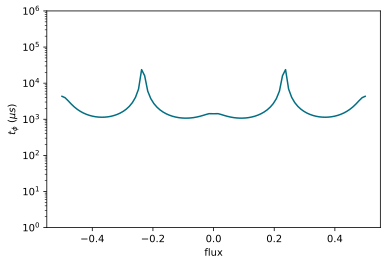

In [74]:
qubit=fluxonium

param_array=np.linspace(-0.5, 0.5, 100)

def calc(param , qubit=qubit): return qubit.set_and_return('flux', param).tphi_1_over_f_cc() * 1e-3
results_array=list(map_fun(calc, param_array))


fig, ax=plt.subplots(1,1)
ax.plot(param_array, results_array)
ax.set_yscale('log')
ax.set_ylabel(r'$t_\phi$ ($\mu s$)')
ax.set_xlabel(r'flux')
ax.set_ylim(1, 1e6);